<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/NDWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Tewabe Melkamu

Date: 3/13/2025

NDWI_Data Collection

In [1]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-melkatewabe')

In [ ]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the FAO GAUL 2015 dataset.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# Load the first image from ESA WorldCover and clip it to Taiwan.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# Class definitions from ESA WorldCover:
# 50 = Built-up, 80 = Permanent water bodies.
# We remove both built-up and permanent water by keeping pixels that are not 50 and not 80.
mask = worldcover.neq(50).And(worldcover.neq(80))

# -------------------------------------------------------------------
# 3. Define cloud masking and NDWI computation functions.
# -------------------------------------------------------------------
def maskClouds(image):
    # Select the quality band that contains cloud information.
    qa = image.select('StateQA')
    # Assume that bit 10 indicates clouds. (1 << 10) creates a bitmask with bit 10 set.
    cloudBitMask = 1 << 10
    # Use a bitwise AND to check whether the cloud bit is set.
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0)
    # Update the image mask so that cloudy pixels are removed.
    return image.updateMask(cloudMask)

def compute_ndwi(image):
    # Convert scaled surface reflectance to true reflectance.
    nir = image.select('sur_refl_b02').multiply(0.0001)
    swir = image.select('sur_refl_b07').multiply(0.0001)
    # Compute NDWI = (NIR - SWIR) / (NIR + SWIR)
    ndwi = nir.subtract(swir).divide(nir.add(swir)).rename('NDWI')
    return image.addBands(ndwi)

# -------------------------------------------------------------------
# 4. Loop through each year from 2005 to 2025 and export the yearly mean NDWI
# -------------------------------------------------------------------
for year in range(2000, 2003):
    print(f"Processing year: {year}")

    # Define the date range for the year.
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    # Load the MODIS/061/MYD09A1 image collection for the given year and filter to Taiwan.
    collection = (ee.ImageCollection('MODIS/061/MYD09A1')
                  .filterDate(start_date, end_date)
                  .filterBounds(taiwan))

    # Apply cloud masking and compute NDWI for each image.
    collection = collection.map(maskClouds).map(compute_ndwi)

    # Compute the mean NDWI for the year and clip to Taiwan.
    ndwi_mean = collection.select('NDWI').mean().clip(taiwan)

    # Apply the ESA WorldCover mask.
    ndwi_masked = ndwi_mean.updateMask(mask)

    # Define and start the export task.
    task = ee.batch.Export.image.toDrive(
        image=ndwi_masked,
        description=f'NDWI_{year}',
        folder='Taiwan_NDWI',  # Update to your desired Google Drive folder.
        fileNamePrefix=f'NDWI_{year}',
        region=taiwan.geometry().bounds().getInfo()['coordinates'],
        scale=1000,  # Typical resolution for MODIS surface reflectance products.
        crs='EPSG:32651',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for {year} started. Please check your GEE tasks and Google Drive.")

# -------------------------------------------------------------------
# (Optional) Create an interactive map to visualize the final NDWI image.
# -------------------------------------------------------------------
# Uncomment the lines below to display an interactive map.
# Map = geemap.Map(center=[23.5, 121], zoom=7)
# Map.addLayer(ndwi_masked, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDWI Masked')
# Map.addLayer(taiwan, {}, 'Taiwan Boundary')
# Map.addLayerControl()  # Enable layer control
# Map


In [ ]:
!pip install rasterio

Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


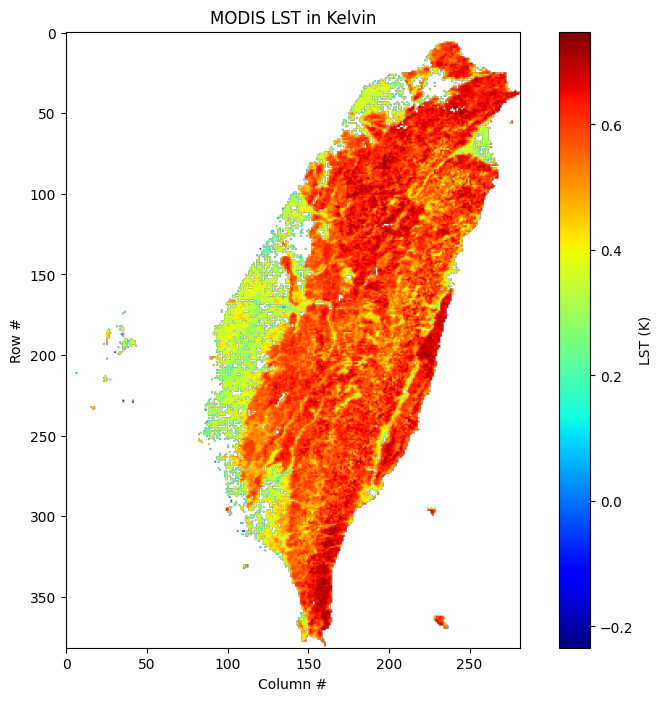

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/Taiwan_NDWI/NDWI_2024.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
lst_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(lst_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()